# Initial demo of model output via Thredds and NLDI
* demo uses siphon to search existing thredds catalog of onhm ouput (note this is still very experimental).  
* seg_outflow is assigned to a variable
* oNHM data for GFv1.1 is read locally - primarily the POIs.  Currently this is the missing functionality, ultimately would like this to be searchable through NLDI (best) or perhaps through WFS on sciencebase (acceptable). POIs provide the cross-walk between the specific model fabric, and the common NHD+ fabric.
* NLDI is searched for all gages and streamsegments upstream of gage 06759500 on the S. Platte River at Fort Morgan.
* GFv1.1 POI is filtered by returned comids from search above.
* Further this is filtered for POIs that are gages(eg. poi.Type_Gage > 0)
* Example comparison is given for observed and simulated streamflow 

We use existing packages to search NLDI and NWIS, and THREDDS

In [1]:
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import dataretrieval.nwis as nwis
from siphon.catalog import TDSCatalog

In [2]:
# Current test location of NHM ouput
catalog = TDSCatalog("http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/catalog/ONHM_OUTPUT/files/catalog.xml")

ConnectionError: HTTPConnectionPool(host='gdp-netcdfdev.cr.usgs.gov', port=8080): Max retries exceeded with url: /thredds/catalog/ONHM_OUTPUT/files/catalog.xml (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000272426156D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [3]:
info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(
    catalog.base_tds_url, catalog.catalog_name, catalog.catalog_url, catalog.metadata
)

print(info)


Catalog information
-------------------

Base THREDDS URL: http://gdp-netcdfdev.cr.usgs.gov:8080
Catalog name: No name found
Catalog URL: http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/catalog/ONHM_OUTPUT/files/catalog.xml
Metadata: {'inherited': True, 'serviceName': 'all'}



In [4]:
for service in catalog.services:
    print(service.name)

all


In [5]:
print("\n".join(catalog.datasets.keys()))

unused_potet.nc
transp_on.nc
tminf.nc
tmaxf.nc
tavgf.nc
swrad.nc
ssres_flow.nc
sroff.nc
soil_to_ssr.nc
soil_to_gw.nc
soil_rechr.nc
soil_moist_tot.nc
soil_moist.nc
snowmelt.nc
snowcov_area.nc
snow_free.nc
snow_evap.nc
slow_stor.nc
slow_flow.nc
seg_width.nc
seg_tave_water.nc
seg_tave_upstream.nc
seg_tave_sroff.nc
seg_tave_lat.nc
seg_tave_gw.nc
seg_tave_air.nc
seg_shade.nc
seg_outflow.nc
recharge.nc
prmx.nc
pref_flow_stor.nc
pref_flow.nc
potet.nc
pkwater_equiv.nc
pk_temp.nc
pk_precip.nc
pk_ice.nc
pk_depth.nc
perv_actet.nc
newsnow.nc
net_snow.nc
net_rain.nc
net_ppt.nc
intcp_on.nc
infil.nc
hru_streamflow_out.nc
hru_sroffp.nc
hru_sroffi.nc
hru_snow.nc
hru_rain.nc
hru_ppt.nc
hru_outflow.nc
hru_lateral_flow.nc
hru_intcpstor.nc
hru_intcpevap.nc
hru_impervstor.nc
hru_impervevap.nc
hru_actet.nc
hortonian_flow.nc
gwres_stor.nc
gwres_in.nc
gwres_flow.nc
freeh2o.nc
dunnian_flow.nc
dprst_vol_open_frac.nc
dprst_vol_open.nc
dprst_stor_hru.nc
dprst_sroff_hru.nc
dprst_seep_hru.nc
dprst_insroff_hru.nc
dpr

In [6]:
dataset = 'seg_outflow.nc'
ds = catalog.datasets[dataset]
print(ds.name, ds.url_path, ds.access_urls, type(ds))

seg_outflow.nc ONHM_OUTPUT/files/seg_outflow.nc {'OPENDAP': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/dodsC/ONHM_OUTPUT/files/seg_outflow.nc', 'UDDC': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/uddc/ONHM_OUTPUT/files/seg_outflow.nc', 'ISO': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/iso/ONHM_OUTPUT/files/seg_outflow.nc', 'NCML': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/ncml/ONHM_OUTPUT/files/seg_outflow.nc', 'NetcdfSubset': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/ncss/ONHM_OUTPUT/files/seg_outflow.nc'} <class 'siphon.catalog.Dataset'>


In [7]:
data = ds.remote_access(service='OPENDAP', use_xarray=True)

In [8]:
data

<xarray.Dataset>
Dimensions:      (nsegment: 58489, time: 14975)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * nsegment     (nsegment) int32 1 2 3 4 5 6 ... 58485 58486 58487 58488 58489
Data variables:
    nhm_seg      (nsegment) int32 ...
    seg_outflow  (time, nsegment) float32 ...
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
data.seg_outflow.attrs

{'long_name': 'Streamflow leaving a segment', 'units': 'cfs'}

### We use only the NHM POIs.  The NHM POI layer  and NHM segments are exported from the GFv1.1 repo on sciencebase.
* GFv1.1 Point of interest (POI): NLDIPlusID == NHD+ comid
* seg_id_nhm (NHM) - what is selected from Thredds ouput


In [10]:
gfv11_filepath = Path('../../Gfv1.1')
print (f'gfv1.1 path exists?: {gfv11_filepath.exists()}')
gfv11_poi = gpd.read_file(gfv11_filepath / 'POIs_v1_1.gpkg')
seg = gpd.read_file(gfv11_filepath / 'nsegment_v1_1.gpkg')

gfv1.1 path exists?: True


C:\Users\rmcd\Miniconda3\envs\nldi_xstool\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


NHDPlusID values are in scientific notation so need to convert to int64

In [11]:
gfv11_poi.NHDPlusID = gfv11_poi.NHDPlusID.astype('int64')

In [12]:
gfv11_poi.NHDPlusID

0         5000100002857
1         5000100004284
2         5000100012160
3         5000100000689
4         5000100002063
              ...      
58186          22226812
58187    10000900096921
58188    55000800119873
58189    55000800050349
58190    55000800241941
Name: NHDPlusID, Length: 58191, dtype: int64

Use Hydrodata python interface to NLDI: https://github.com/cheginit/hydrodata

In [13]:
import hydrodata as hd
from hydrodata import NWIS, plot

### Search NLDI by navigating above USGS-06759500 gage on S. Platt River above Fort Morgan, CO
* grab all comids and gages on main flowline.  
* Use station comids to filter NHM POIs

In [14]:
gage_id = '06759500'
nldi_flw_main = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="flowlines",
                             distance=50)

nldi_st_all = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="nwissite",
                             distance=50)

ndli_POI_all =  NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="gfv11_pois",
                             distance=50)

In [15]:
nldi_flw_main.head()

,geometry,nhdplus_comid
0,"LINESTRING (-103.80253 40.26874, -103.80151 40...",3561878
1,"LINESTRING (-103.82914 40.27436, -103.82747 40...",3561874
2,"LINESTRING (-103.83380 40.27505, -103.83288 40...",3561872
3,"LINESTRING (-103.84725 40.28259, -103.84632 40...",3561928
4,"LINESTRING (-103.84846 40.28266, -103.84830 40...",3561850


In [16]:
nldi_st_all.head()

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-104.24467 40.30637),nwissite,NWIS Sites,USGS-401823104143900,"SOUTH PLATTE RIVER AT MASTERS, CO",https://waterdata.usgs.gov/monitoring-location...,226643,10190003000027,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...
1,POINT (-103.92028 40.32139),nwissite,NWIS Sites,USGS-06758500,"SOUTH PLATTE RIVER NEAR WELDONA, CO",https://waterdata.usgs.gov/monitoring-location...,227923,10190003000022,97.20807,https://labs.waterdata.usgs.gov/api/nldi/linke...
2,POINT (-103.80119 40.26840),nwissite,NWIS Sites,USGS-06759500,"SOUTH PLATTE RIVER AT FORT MORGAN, CO",https://waterdata.usgs.gov/monitoring-location...,3561878,10190012002368,94.85288,https://labs.waterdata.usgs.gov/api/nldi/linke...
3,POINT (-104.24495 40.30581),nwissite,NWIS Sites,USGS-06756995,"SOUTH PLATTE RIVER AT MASTERS, CO.",https://waterdata.usgs.gov/monitoring-location...,226669,10190003001241,97.32596,https://labs.waterdata.usgs.gov/api/nldi/linke...
4,POINT (-104.17912 40.30387),nwissite,NWIS Sites,USGS-06757000,"SOUTH PLATTE RIVER AT SUBLETTE, CO.",https://waterdata.usgs.gov/monitoring-location...,226665,10190003001241,53.22072,https://labs.waterdata.usgs.gov/api/nldi/linke...


In [17]:
ndli_POI_all.head()

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-103.90353 40.31102),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,24273,South Platte River,https://geoconnex.us/usgs/gfv11_pois/24273,227923,10190003000022,68.92192,https://labs.waterdata.usgs.gov/api/nldi/linke...
1,POINT (-103.79559 40.26779),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,24735,South Platte River,https://geoconnex.us/usgs/gfv11_pois/24735,3561878,10190012002368,88.41941,https://labs.waterdata.usgs.gov/api/nldi/linke...
2,POINT (-104.07625 40.34529),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,28418,South Platte River,https://geoconnex.us/usgs/gfv11_pois/28418,24847469,10190003002288,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...
3,POINT (-103.86086 40.28574),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,24274,South Platte River,https://geoconnex.us/usgs/gfv11_pois/24274,227925,10190003000022,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...


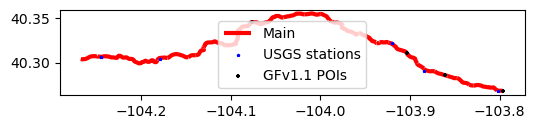

In [22]:
ax = nldi_flw_main.plot(
    lw=3, color="r", zorder=2, label="Main"
)
nldi_st_all.plot(
    ax = ax, label="USGS stations", marker="*", markersize=3, zorder=4, color="b"
)
ndli_POI_all.plot(ax = ax, label="GFv1.1 POIs", marker="+", markersize=12, zorder=5, color="black")
ax.legend(loc="best")
ax.set_aspect("equal")
ax.figure.set_dpi(100)

In [18]:
nldi_st_all.comid.values

array(['226643', '227923', '3561878', '226669', '226665', '227969'],
      dtype=object)

Filter NHM POI for all NHDPlusIDs in the NLDI station records

In [19]:
gfv11_poi_filt = gfv11_poi[gfv11_poi.NHDPlusID.isin(nldi_st_all.comid.values.astype('int64'))]

Identify gage POI ie Type_Gage > 0

In [20]:
gfv11_poi_gage = gfv11_poi_filt[gfv11_poi_filt.Type_Gage.astype(int) > 0]
gfv11_poi_gage.head()

,OBJECTID,GNIS_Name,NHDPlusID,HydroSeq,Type_conf,Type_WBOut,Type_WBIn,Type_Gage,Type_Ref,Type_Con,Type_GFv1,Type_Travel,Type_Elev,Gage_Source,Type_NCA,seg_id_nhm,poi_segment_v1_1,NHD_Unit,geometry
32303,32304,South Platte River,227923,918700008.0,0,0,0,06758500,Non-ref,0,0,0,0,V1 Type_GagesII field,0,24273,24273,10L,POINT Z (-665152.251 1949498.999 0.000)
32304,32305,South Platte River,3561878,917000432.0,0,0,0,06759500,Non-ref,0,0,0,0,V1 Type_GagesII field,0,24735,24735,10L,POINT Z (-656485.620 1943921.127 0.000)


grab the nhm segment id for a gage of interest

In [21]:
nhm_seg_id = gfv11_poi_gage.loc[gfv11_poi_gage.Type_Gage == '06758500'].seg_id_nhm.values[0]
nhm_seg_id

24273

In [22]:
nhm_seg_ouflow = data.isel(nsegment=nhm_seg_id)
nhm_seg_ouflow_cms = nhm_seg_ouflow.seg_outflow * 0.02381

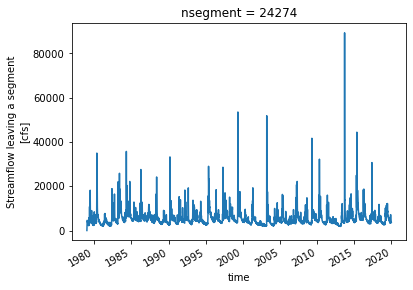

In [23]:
ax = nhm_seg_ouflow.seg_outflow.plot()

### Experiment with a couple packages for retrieving NWIS data.
* hydrodata NWIS package (NWIS)
* dataretreival package (nwis)

In [24]:
site='06758500'
df = nwis.get_record(sites=site, service='dv', start='1980-10-01',  parameterCd='00060')

In [25]:
df

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
1980-10-01 00:00:00+00:00,318.0,A,06758500
1980-10-02 00:00:00+00:00,295.0,A,06758500
1980-10-03 00:00:00+00:00,288.0,A,06758500
1980-10-04 00:00:00+00:00,285.0,A,06758500
1980-10-05 00:00:00+00:00,274.0,A,06758500
...,...,...,...
2007-09-25 00:00:00+00:00,203.0,A,06758500
2007-09-26 00:00:00+00:00,363.0,A,06758500
2007-09-27 00:00:00+00:00,564.0,A,06758500


In [26]:
from hydrodata import NWIS
qobs = NWIS().get_streamflow(site, ("1980-01-01", "2007-12-31"))

In [27]:
type(qobs['USGS-06758500'])

pandas.core.series.Series

# Comparison of observed vs simulated

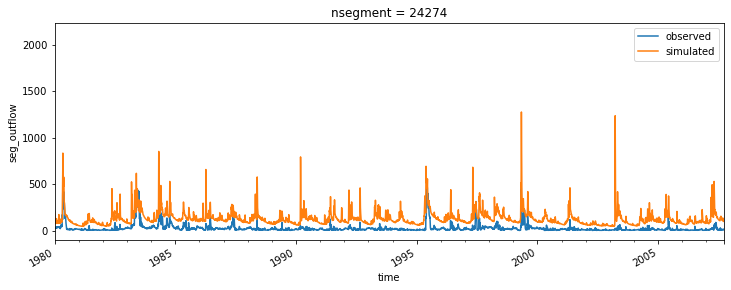

In [28]:
fig, axs = plt.subplots(figsize=(12, 4))
qobs['USGS-06758500'].plot(ax=axs, label="observed")
nhm_seg_ouflow_cms.plot(ax=axs, label="simulated")
axs.legend()

In [29]:
qobs

,USGS-06758500
dateTime,
1980-01-01,24.947142
1980-01-02,26.561202
1980-01-03,25.541796
1980-01-04,25.343578
1980-01-05,25.485162
...,...
2007-09-25,5.748320
2007-09-26,10.279015
2007-09-27,15.970701
